<a href="https://colab.research.google.com/github/quynhkylaphan/python-projects/blob/main/company_trend_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up

## Import Modules

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Variable Definitions

In [ ]:
#apply to https://wrds-www.wharton.upenn.edu/register to get your API key; this can take several days to be confirmed
#once you have your login, go to https://wrds-api.wharton.upenn.edu/ to get your API key
apikeyWRDS = '90ad37d3e26e3d6d9bad9448dd43dcdd1a74b67c'

#this is the standards WRDS URL that gets you to Wharton but to make a call, you ALSO must supply an endpoint
urlWRDS = "https://wrds-api.wharton.upenn.edu/data/"

#provided dataset of companies BoardEx Company ID, CRSP Permco, Ticker, Compustat GVKEY, and Raven Pack Entity ID
#will need to use this dataframe to link data across different libraries
companyCodes = pd.read_csv("https://raw.githubusercontent.com/SueMcMetzger/MIS2020/main/WRDS_LINKS.csv", dtype={'Compustat_GVKEY': str})

## Function Definitions

### WRDS API

In [ ]:
# get data from Wharton WRDS API with a specific authorization token,
# the data endpoint/URL, and a dictionary or parameters defining the query
def apiWRDS(url, options=''):
    try:
        header = {'Authorization' : 'Token '+ apikeyWRDS}
        response = requests.get(url, headers=header, params=options)
        if response.status_code != 200:
            raise
        data = response.json()
        return data
    except:
        print("WRDS call was not successful.")
        return None

### Average Executive Compensation

In [ ]:
# Create a function to calculate the average executive compensation for a given company within a specified year range.

def calculate_average_compensation(ticker, start_year, end_year):
    try:
        # 1. Get GVKEY from ticker
        gvkey = companyCodes.query(f'TICKER == "{ticker}"').iloc[0].Compustat_GVKEY
        print(f"GVKEY for {ticker}: {gvkey}")

        # 2. Fetch compensation data
        endpoint_compensation = 'ciq.wrds_compensation'
        options_compensation = {
            'gvkey': gvkey,
            'limit': 20000
        }
        data_compensation = apiWRDS(urlWRDS + endpoint_compensation, options_compensation)

        if not data_compensation:
            print("Failed to retrieve compensation data.")
            return None

        # 3. Process and prepare compensation data: convert to DataFrame, add gvkey, select columns, rename, and handle missing values.
        results_compensation = pd.DataFrame(data_compensation.get('results'))
        results_compensation['gvkey'] = options_compensation['gvkey']
        results_compensation = results_compensation[['companyname', 'year', 'title', 'ctype18', 'gvkey']]
        results_compensation = results_compensation.rename(columns={'ctype18': 'total compensation'})
        results_compensation = results_compensation.dropna(subset=['total compensation'])

        # 4. Filter by year range
        results_compensation = results_compensation[
            (results_compensation['year'] >= start_year) & (results_compensation['year'] <= end_year)]

        # 5. Calculate average compensation
        grouped_results_compensation = results_compensation.groupby('year')['total compensation'].mean().reset_index()
        grouped_results_compensation['total compensation'] = grouped_results_compensation['total compensation'].round(2)
        grouped_results_compensation.rename(columns={'total compensation': 'average compensation (million $)'}, inplace=True)

        return grouped_results_compensation

    except IndexError:
        print(f"Ticker {ticker} not found in the companyCodes DataFrame.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

###  Fortune 500 Web Scraping

In [ ]:
merged_df = pd.read_csv('https://raw.githubusercontent.com/quynhkylaphan/fortune500/refs/heads/main/merged_df.csv')

# filter all company dont have ticker (private company or etc)
fortune_df = merged_df[merged_df['ticker'].notna()]

### Average Executive Compensation v. Fortune Ranking

In [ ]:
def analyze_compensation_ranking(ticker, start_year, end_year):
    """
    Analyzes the relationship between a company's average executive compensation and its Fortune ranking
    over a specified time period.
    """
    # Fetch average compensation data
    average_compensation_df = calculate_average_compensation(ticker, start_year, end_year)

    if average_compensation_df is not None:
        # Fetch Fortune ranking data
        fortune_ranking_df = fortune_df[
            (fortune_df['ticker'] == ticker) &
            (fortune_df['year'] >= start_year) &
            (fortune_df['year'] <= end_year)
        ][['year', 'rank']]
        fortune_ranking_df['rank'] = pd.to_numeric(fortune_ranking_df['rank'], errors='coerce')

        # Merge datasets
        comp_ranking_df = pd.merge(average_compensation_df, fortune_ranking_df, on='year', how='inner')

        # Check if merged DataFrame is not empty
        if comp_ranking_df.empty:
            print("No overlapping data found for the given ticker and year range.")
            return None

        # Data Inspection
        print("Merged DataFrame:")
        print(comp_ranking_df)

        # Check for NaN values
        comp_ranking_df = comp_ranking_df.dropna(subset=['average compensation (million $)', 'rank'])

        if not comp_ranking_df.empty:
            # Calculate correlation
            correlation = comp_ranking_df['average compensation (million $)'].corr(comp_ranking_df['rank'])
            print(f"\nCorrelation between Average Compensation and Rank: {correlation:.2f}")

            # Plotting
            plt.figure(figsize=(12, 7))

            # Scatter plot
            sns.scatterplot(
                data=comp_ranking_df,
                x='average compensation (million $)',
                y='rank',
                s=100,
            )

            # Handle cases where rank or compensation has no variability
            rank_unique = comp_ranking_df['rank'].nunique()
            compensation_unique = comp_ranking_df['average compensation (million $)'].nunique()

            if rank_unique > 1 and compensation_unique > 1:
                sns.regplot(
                    data=comp_ranking_df,
                    x='average compensation (million $)',
                    y='rank',
                    scatter=False, # Prevents regplot from plotting its own scatter points
                    color='red',
                    label='Trend Line'
                )

            # Adjust axes
            from matplotlib.ticker import MultipleLocator #set fixed intervals for axis ticks in Matplotlib plots
            if rank_unique > 1:
                plt.gca().invert_yaxis() # Use .gca() to get the current axes object and call invert_yaxis() to invert the y-axis
                plt.gca().yaxis.set_major_locator(MultipleLocator(2))  # Set y-axis tick interval to 2
            plt.xlabel('Average Compensation (million $)')
            plt.ylabel('Fortune Ranking')
            plt.title(f'{ticker} Compensation vs. Fortune Ranking ({start_year}-{end_year})')

            # Annotate points
            for _, row in comp_ranking_df.iterrows():
                plt.text(
                    row['average compensation (million $)'],
                    row['rank'],
                    str(int(row['year'])),
                    fontsize=9,
                    verticalalignment='bottom',
                    horizontalalignment='right'
                )

            plt.tight_layout()
            plt.grid(True)
            plt.show()

            return

        else:
            print("No valid data available after handling missing values.")
            return None

### Average Stock Price

In [ ]:
def get_average_stock_price(ticker, start_year, end_year):
    """
    Retrieves monthly stock price data for a given ticker within a specified year range,
    calculates the average monthly price for each year, and renames the date column to 'year'.
    """
    try:
        # 1. Get PERMCO from ticker
        permco = companyCodes.query(f'TICKER == "{ticker}"').iloc[0].CRSP_PERMCO
        print(f"PERMCO for {ticker}: {permco}")

        # 2. Fetch stock price data (using monthly endpoint 'crsp.msf_v2')
        endpoint_monthly = 'crsp.msf_v2'
        options_stockprice = {
            'limit': 10000,
            'permco': permco
        }
        data_stockprice = apiWRDS(urlWRDS + endpoint_monthly, options_stockprice)

        if not data_stockprice:
            print("Failed to retrieve stock price data.")
            return None

        # 3. Process and prepare stock price data
        results_stockprice = pd.DataFrame(data_stockprice.get('results'))

        # 4. Filter by year range using 'mthcaldt'
        results_stockprice['mthcaldt'] = pd.to_datetime(results_stockprice['mthcaldt'], errors='coerce')
        filtered_results = results_stockprice[
            results_stockprice['mthcaldt'].dt.year.between(start_year, end_year)
        ]

        # 5. Select and rename columns
        filtered_results = filtered_results[['mthcaldt', 'mthprc']]
        filtered_results = filtered_results.rename(columns={
            'mthcaldt': 'date',
            'mthprc': 'average stock price'
        })

        # 6. Convert 'monthly price' to numeric
        filtered_results['average stock price'] = pd.to_numeric(filtered_results['average stock price'], errors='coerce')

        # 7. Calculate average monthly price for each year and rename 'date' to 'year'
        filtered_results['year'] = filtered_results['date'].dt.year  # Extract year
        average_stock_price = filtered_results.groupby('year')['average stock price'].mean().reset_index()

        return average_stock_price

    except IndexError:
        print(f"Ticker {ticker} not found in the companyCodes DataFrame.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

### Average Stock Price v. Average Executive Compensation

In [ ]:
def plot_stock_compensation(ticker, start_year, end_year):
    """
    Plots the average monthly stock price and average compensation for a given company
    over a specified time period in a combined scatterplot.
    Includes year annotations next to the dots and a trend line.
    """
    # Fetch stock price data
    stock_data = get_average_stock_price(ticker, start_year, end_year)

    # Fetch compensation data
    compensation_data = calculate_average_compensation(ticker, start_year, end_year)

    if stock_data is not None and compensation_data is not None:

        # Merge the DataFrames
        merged_stockprice_compensation = pd.merge(stock_data, compensation_data, on='year', how='inner')
        if merged_stockprice_compensation.empty:
            print("No overlapping data found for stock price and compensation.")
            return

        # Calculate correlation
        correlation = merged_stockprice_compensation['average stock price'].corr(merged_stockprice_compensation['average compensation (million $)'])
        print(f"Correlation between Average Stock Price and Average Compensation: {correlation:.2f}")

        # Create the scatter plot
        plt.figure(figsize=(10, 5))
        # Added trend line using sns.regplot
        sns.regplot(
            x='average stock price',
            y='average compensation (million $)',
            data=merged_stockprice_compensation,
            scatter=False,
            color='red',
            label='Trend Line'
        )
        sns.scatterplot(
            x='average stock price',
            y='average compensation (million $)',
            data=merged_stockprice_compensation,
            s=100
        )

        # Annotate points with year
        for _, row in merged_stockprice_compensation.iterrows():
            plt.text(
                row['average stock price'],
                row['average compensation (million $)'],
                str(int(row['year'])),
                fontsize=9,
                verticalalignment='bottom',
                horizontalalignment='right'
            )

        plt.xlabel('Average Monthly Stock Price')
        plt.ylabel('Average Compensation (million $)')
        plt.title(f'{ticker} Average Monthly Stock Price vs. Average Compensation ({start_year}-{end_year})')
        plt.grid(True)
        plt.show()
    else:
        print("Could not retrieve stock or compensation data.")

### Top 5 Companies Comparison

In [ ]:
def compare_stock_prices(ticker, start_year, end_year):
    """
    Finds 4 more companies in the same industry, plots a graph to compare
    stock prices, and includes company rankings over the specified period.
    """
    try:
        # 1. Find the industry and company name of the input company
        company_info = fortune_df[fortune_df['ticker'] == ticker].iloc[0]
        industry = company_info['industry']
        company_name = company_info['name']
        print(f"Company name: {company_name}")
        print(f"Industry: {industry}")

        # 2. Find 4 more companies in the same industry
        other_companies_info = fortune_df[
            (fortune_df['industry'] == industry) & (fortune_df['ticker'] != ticker)
        ].head(4)
        other_companies = other_companies_info['ticker'].tolist()
        print(f"Other companies in the same industry: {other_companies}")

        # Combine with input ticker and company name
        companies = [(ticker, company_name)] + list(zip(other_companies, other_companies_info['name']))

        # 3. Get stock and ranking data for each company
        stock_data = {}
        ranking_data = {}
        for company_ticker, company_name in companies:
            stock_price_data = get_average_stock_price(company_ticker, start_year, end_year)
            if stock_price_data is not None:
                stock_data[company_name] = stock_price_data

            # Get ranking data
            company_ranking_data = fortune_df[
                (fortune_df['ticker'] == company_ticker) &
                (fortune_df['year'] >= start_year) &
                (fortune_df['year'] <= end_year)
            ][['year', 'rank']]
            if not company_ranking_data.empty:
                ranking_data[company_name] = company_ranking_data
            else:
                print(f"Could not retrieve ranking data for company: {company_name}")

        # 4. Create a table with stock prices and rankings
        all_data = {}
        for company_name, stock_data_df in stock_data.items():
            stock_data_df = stock_data_df.set_index('year')
            all_data[company_name + ' Stock Price'] = stock_data_df['average stock price']

            if company_name in ranking_data:
                ranking_data_df = ranking_data[company_name].set_index('year')
                all_data[company_name + ' Rank'] = ranking_data_df['rank']

        table_df = pd.DataFrame(all_data)
        display(table_df)  # Display the table

        # 5. Plot the stock price data
        plt.figure(figsize=(10, 5))
        for company_name, data in stock_data.items():
            if not data.empty:
                plt.plot(data['year'], data['average stock price'], label=company_name)

        plt.xlabel("Year")
        plt.ylabel("Average Stock Price")
        plt.title(f"Stock Price Comparison ({start_year}-{end_year})")
        plt.legend()
        plt.grid(True)
        plt.show()

        # 6. Plot the ranking data in a separate graph
        plt.figure(figsize=(10, 5))
        for company_name, data in ranking_data.items():
            if not data.empty:
                plt.plot(data['year'], data['rank'], label=f"{company_name} Rank")

        plt.xlabel("Year")
        plt.ylabel("Fortune Ranking")
        plt.title(f"Ranking Comparison ({start_year}-{end_year})")
        plt.legend()
        plt.gca().invert_yaxis()  # Invert y-axis for rankings (lower is better)
        plt.grid(True)
        plt.show()

    except IndexError:
        print(f"Ticker {ticker} not found or no other companies found in the same industry.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Application

## User Inputs

In [ ]:
ticker = input('Enter a company ticker: ')
start_year = int(input('Enter the start year: '))
end_year = int(input('Enter the end year: '))

Enter a company ticker: NKE
Enter the start year: 2014
Enter the end year: 2020


## Average Executive Compensation v. Fortune Ranking

GVKEY for NKE: 007906
Merged DataFrame:
     year  average compensation (million $)  rank
0  2014.0                        2147960.56   115
1  2015.0                        2337952.88   106
2  2016.0                        3978271.79    91
3  2017.0                        2116132.19    88
4  2018.0                        3043975.33    89
5  2019.0                        2232581.89    90
6  2020.0                        5541584.71    85

Correlation between Average Compensation and Rank: -0.51


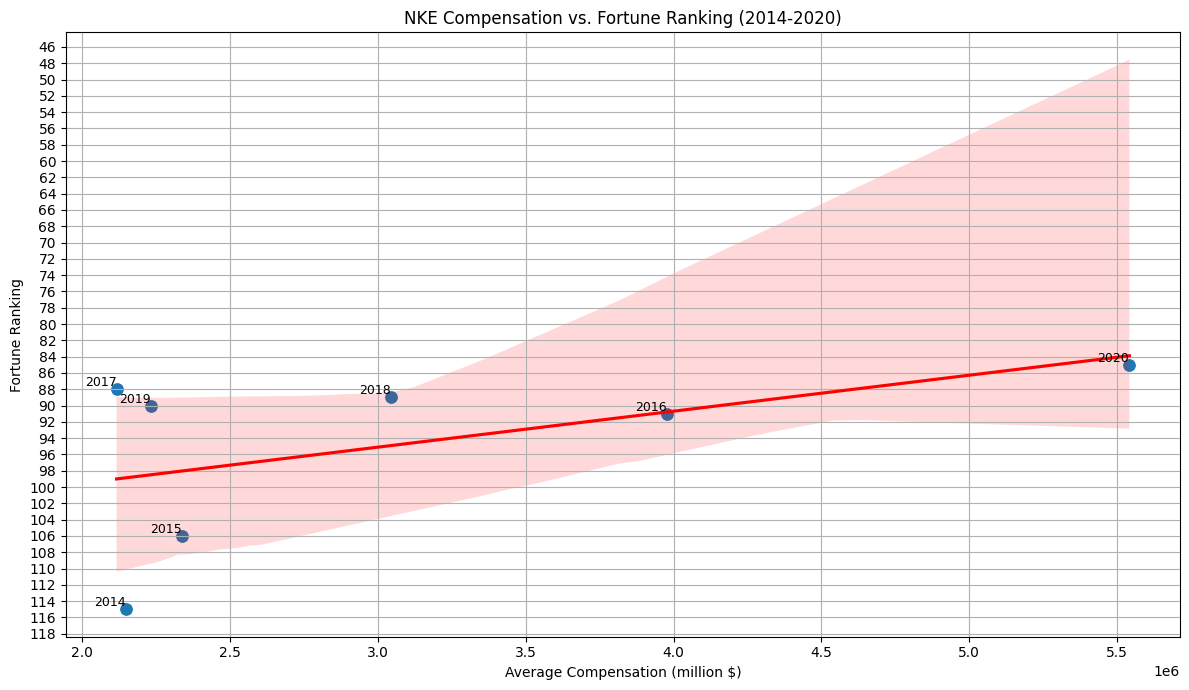

In [ ]:
comp_ranking_result = analyze_compensation_ranking(ticker, start_year, end_year)

if comp_ranking_result is not None:
    print(comp_ranking_result)

## Average Stock Price v. Average Executive Compensation

PERMCO for NKE: 3194
GVKEY for NKE: 007906
Correlation between Average Stock Price and Average Compensation: 0.25


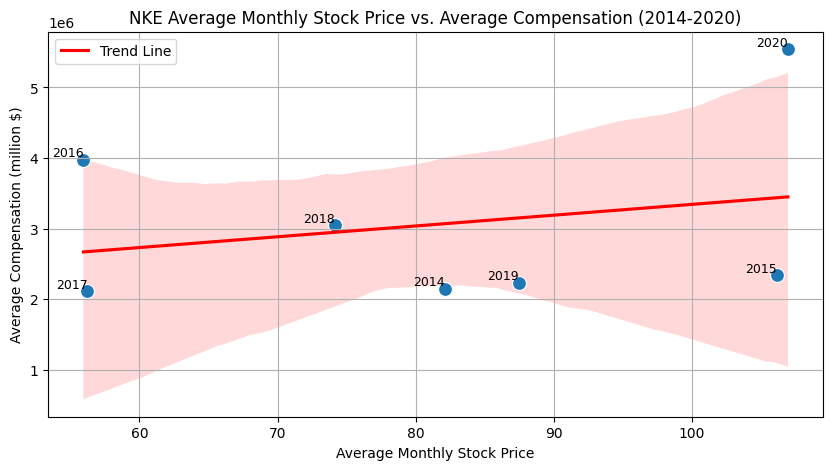

In [ ]:
plot_stock_compensation(ticker, start_year, end_year)

## Top 5 Companies Comparison

Company name: Nike
Industry: Apparel
Other companies in the same industry: ['VFC', 'PVH', 'RL', 'TPR']
PERMCO for NKE: 3194
PERMCO for VFC: 21849
PERMCO for PVH: 21402
PERMCO for RL: 32009
PERMCO for TPR: 40143


,Nike Stock Price,Nike Rank,VF Stock Price,VF Rank,PVH Corp. Stock Price,PVH Corp. Rank,Ralph Lauren Stock Price,Ralph Lauren Rank,Tapestry Stock Price,Tapestry Rank
year,,,,,,,,,,
2014,82.142500,115,64.600000,241,121.966667,330,164.094167,374,40.164167,489
2015,106.165000,106,70.511667,248,103.282500,351,127.805833,374,34.703333,535
2016,55.941667,91,60.160833,231,96.475000,340,97.713333,354,38.471667,575
2017,56.238333,88,60.847500,230,115.014167,335,84.316667,371,42.141667,546
2018,74.140833,89,82.211667,242,140.459167,332,120.992500,421,46.485833,555
2019,87.461667,90,87.575000,252,99.745000,324,110.829167,473,29.670833,484
2020,106.960000,85,68.046667,233,61.450000,322,81.007500,469,19.106667,485


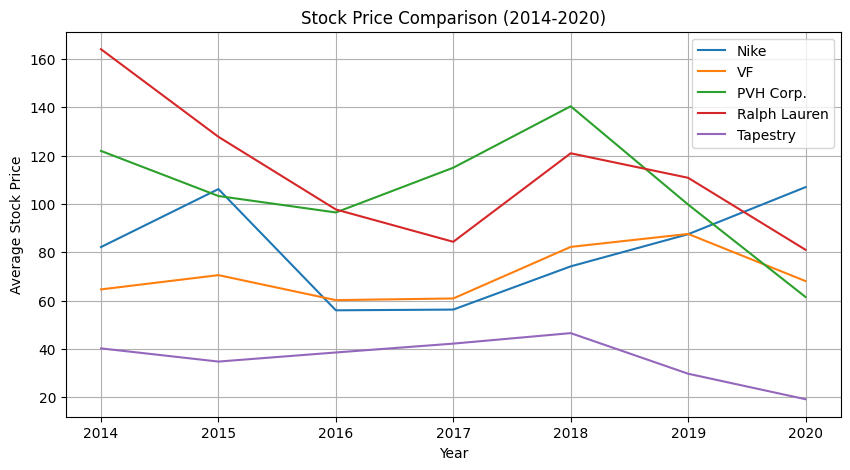

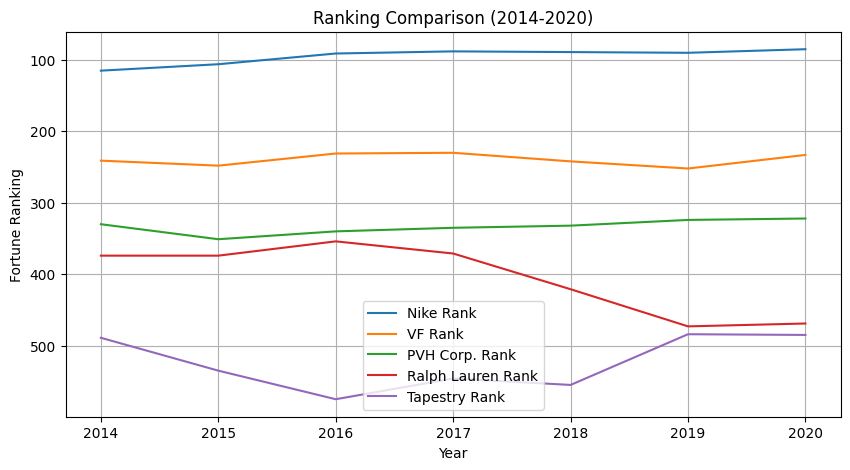

In [ ]:
compare_stock_prices(ticker, start_year, end_year)